In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import pandas as pd

import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class DFImageDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        """
        Args:
            csv_path : path of dataset's CSV file
            transform : Optional transform to be applied on a sample.

        df : DataFrame with columns ['img_path', 'label']
        """
        self.df = pd.read_csv(csv_path, header=0)
        self.df.columns = ["idx", "filename", "label"] if self.df.shape[1] == 3 else ["filename"]
        self.df.pop('idx') if 'idx' in self.df.columns else None
        
        self.transform = transform

        # Check the first few rows
        print("Data loaded successfully!")
        print(self.df.head())
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(dataset_folder+row['filename']).convert("RGB")
        label = int(row['label'])
        if self.transform:
            img = self.transform(img)
        return img, label


In [3]:
# Path to CSV files
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv" 

In [4]:
# Load and preprocess an random image
dataset_folder = "/kaggle/input/ai-vs-human-generated-dataset/"

label_dict = {
    0: 'HUMAN-gen',
    1 : 'AI-gen'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load the pretrained MobileNetV3-Large model
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

# Replace classifier for 2 labels
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 189MB/s]


In [6]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize(640),
    #transforms.RandomResizedCrop(224),
    transforms.CenterCrop(640),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_tfms = transforms.Compose([
    transforms.Resize(640),
    transforms.CenterCrop(640),
    transforms.ToTensor()
])

# Dataset
trainval_data = DFImageDataset(train_csv_path, transform=train_tfms)
test_data   = DFImageDataset(test_csv_path,   transform=test_tfms)

# Define split sizes
train_size = int(0.85 * len(trainval_data))
val_size   = len(trainval_data) - train_size

# Split
torch.manual_seed(17)
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data,   batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print("num of train iter: ", len(train_loader))


Data loaded successfully!
                                          filename  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Data loaded successfully!
                                            filename
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
num of train iter:  2124


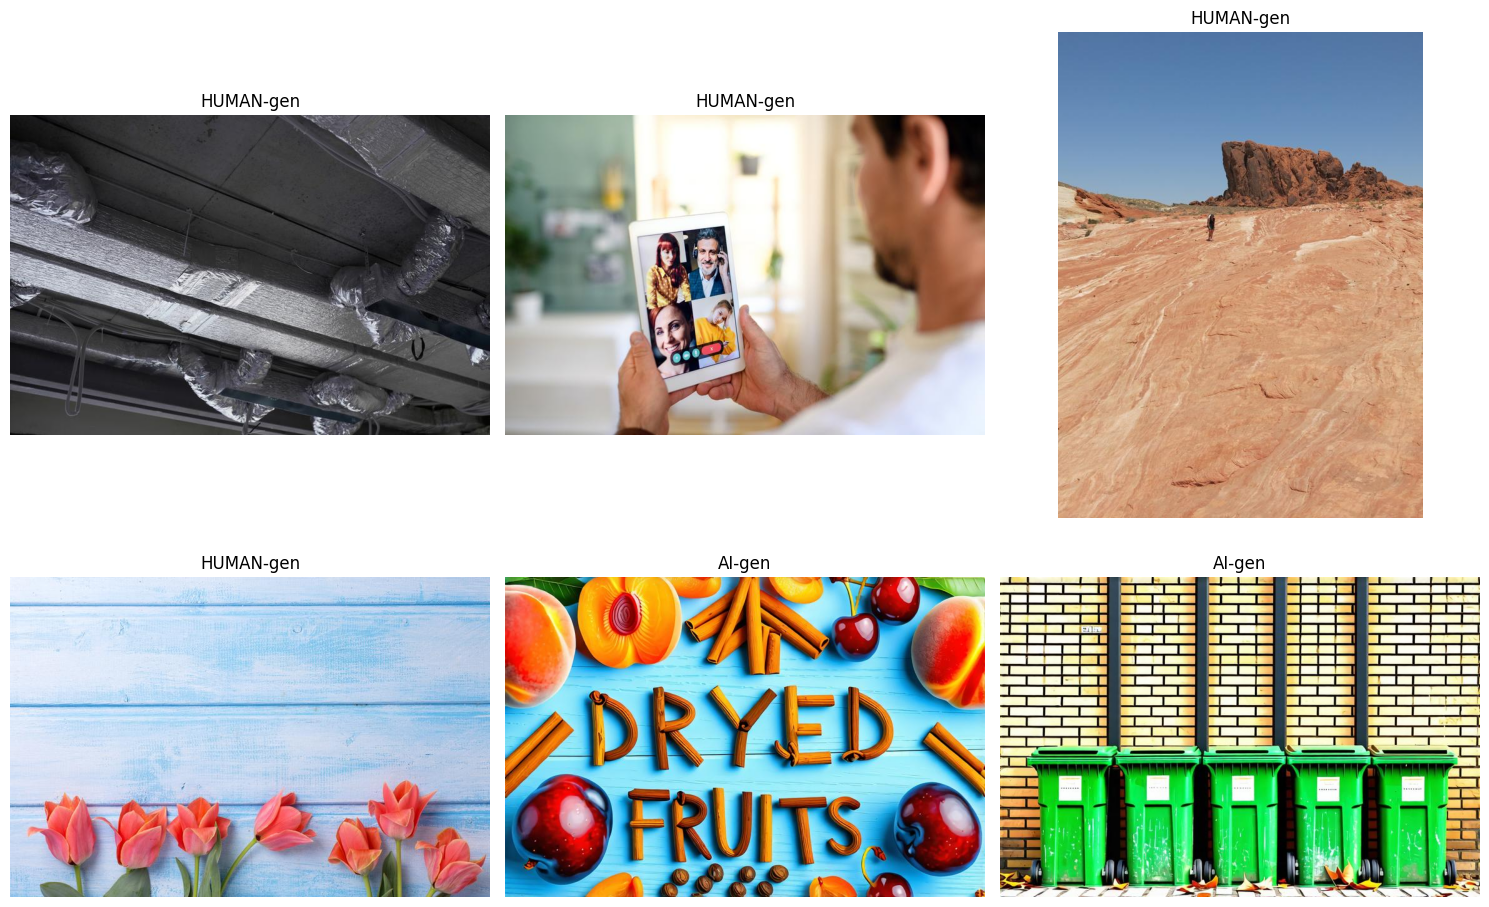

In [7]:
# Assume df already loaded and has a column 'img_path'
# Randomly select 5 rows
sample_df = trainval_data.df.sample(6)  # random_state for reproducibility

# Create a plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):

    img = Image.open(dataset_folder+row['filename']).convert("RGB")
    ax.imshow(img)
    ax.set_title(label_dict.get(row.get('label', ''), ''))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
def eval_model(model, data_loader):
    model.eval().to(device)
    
    # Evaluate
    correct, total = 0, 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            preds = outputs.argmax(1)
    
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy*100:.2f}%  ({correct}/{total})")

In [9]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Training Loop
epochs = 15
max_iter = 100

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects , label_count= 0.0, 0, 0
    
    total_iters = min(max_iter, len(train_loader))
    pbar = tqdm(train_loader, total=total_iters, leave=False)

    for i, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

        label_count += labels.size(0)
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

        if i + 1 >= max_iter:  # stop after max_iter batches
            break
        
    train_loss = running_loss / label_count
    train_acc = running_corrects / label_count

    print(f"Epoch {epoch} | Train loss{train_loss} | Train Acc {train_acc}")

    eval_model(model, val_loader)

Epoch 0 | Train loss0.19151962124742566 | Train Acc 0.91625


100%|██████████| 375/375 [02:56<00:00,  2.12it/s]


Evaluation Accuracy: 97.25%  (11663/11993)


Epoch 1 | Train loss0.058655047584325076 | Train Acc 0.9775


100%|██████████| 375/375 [02:14<00:00,  2.78it/s]


Evaluation Accuracy: 97.87%  (11738/11993)


Epoch 2 | Train loss0.03879778138012625 | Train Acc 0.9846875


100%|██████████| 375/375 [02:17<00:00,  2.73it/s]


Evaluation Accuracy: 97.38%  (11679/11993)


Epoch 3 | Train loss0.03219545378931798 | Train Acc 0.9871875


100%|██████████| 375/375 [02:14<00:00,  2.79it/s]


Evaluation Accuracy: 99.20%  (11897/11993)


Epoch 4 | Train loss0.026530597544333432 | Train Acc 0.989375


100%|██████████| 375/375 [02:16<00:00,  2.74it/s]


Evaluation Accuracy: 99.17%  (11893/11993)


Epoch 5 | Train loss0.02084516037546564 | Train Acc 0.991875


100%|██████████| 375/375 [02:16<00:00,  2.75it/s]


Evaluation Accuracy: 98.41%  (11802/11993)


Epoch 6 | Train loss0.020571564031852178 | Train Acc 0.9925


100%|██████████| 375/375 [02:14<00:00,  2.79it/s]


Evaluation Accuracy: 99.53%  (11937/11993)


Epoch 7 | Train loss0.012041298546973849 | Train Acc 0.995625


100%|██████████| 375/375 [02:17<00:00,  2.73it/s]


Evaluation Accuracy: 99.59%  (11944/11993)


Epoch 8 | Train loss0.011557230060388975 | Train Acc 0.9965625


100%|██████████| 375/375 [02:13<00:00,  2.81it/s]


Evaluation Accuracy: 99.25%  (11903/11993)


Epoch 9 | Train loss0.012242755804109037 | Train Acc 0.995625


100%|██████████| 375/375 [02:16<00:00,  2.76it/s]


Evaluation Accuracy: 99.52%  (11936/11993)


Epoch 10 | Train loss0.018732265184498827 | Train Acc 0.9921875


100%|██████████| 375/375 [02:18<00:00,  2.71it/s]


Evaluation Accuracy: 99.46%  (11928/11993)


Epoch 11 | Train loss0.02458526711561717 | Train Acc 0.9896875


100%|██████████| 375/375 [02:15<00:00,  2.78it/s]


Evaluation Accuracy: 99.14%  (11890/11993)


Epoch 12 | Train loss0.021240032747591613 | Train Acc 0.99375


100%|██████████| 375/375 [02:15<00:00,  2.77it/s]


Evaluation Accuracy: 99.46%  (11928/11993)


Epoch 13 | Train loss0.015154108837014063 | Train Acc 0.995


100%|██████████| 375/375 [02:14<00:00,  2.78it/s]


Evaluation Accuracy: 99.57%  (11941/11993)


Epoch 14 | Train loss0.01481163524906151 | Train Acc 0.994375


100%|██████████| 375/375 [02:27<00:00,  2.54it/s]

Evaluation Accuracy: 99.51%  (11934/11993)


In [11]:
torch.save({
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}, "ai_img_detection_v0-1-3.pt")

## Test new model
Test conducted with validation data since the test dataset doesn't have any label

In [12]:
# Load checkpoint
# Uncomment to load model from input directory

#checkpoint = torch.load("/kaggle/input/ai-detection-model/ai_img_detection_v0-1-3.pt", map_location=device)

#model.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer'])
#start_epoch = checkpoint['epoch']

In [13]:
eval_model(model, val_loader)

100%|██████████| 375/375 [02:15<00:00,  2.76it/s]

Evaluation Accuracy: 99.52%  (11935/11993)


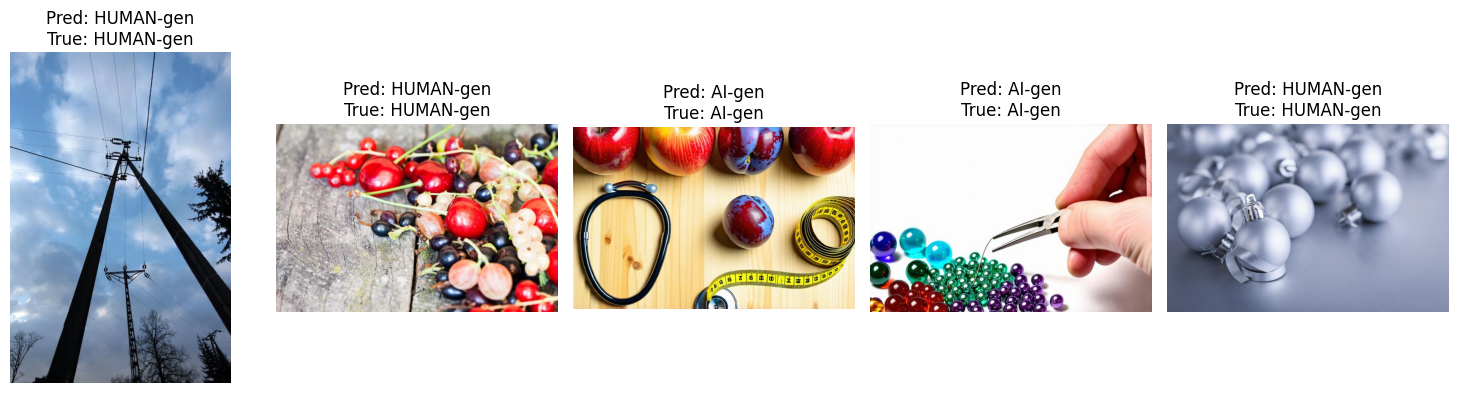

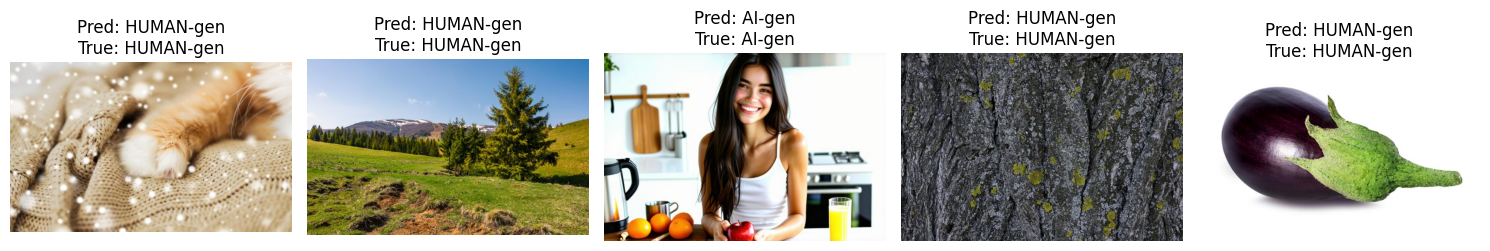

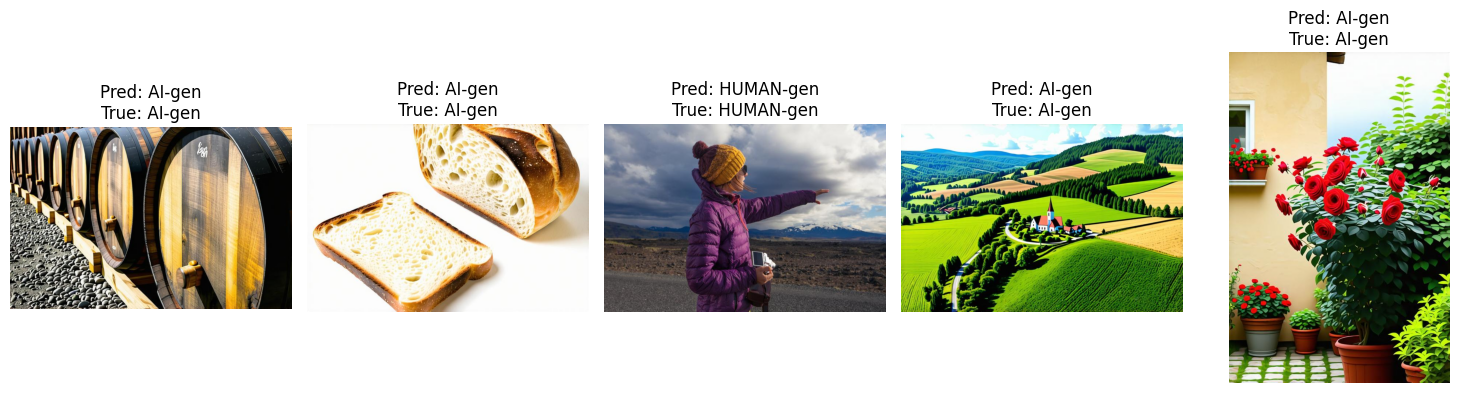

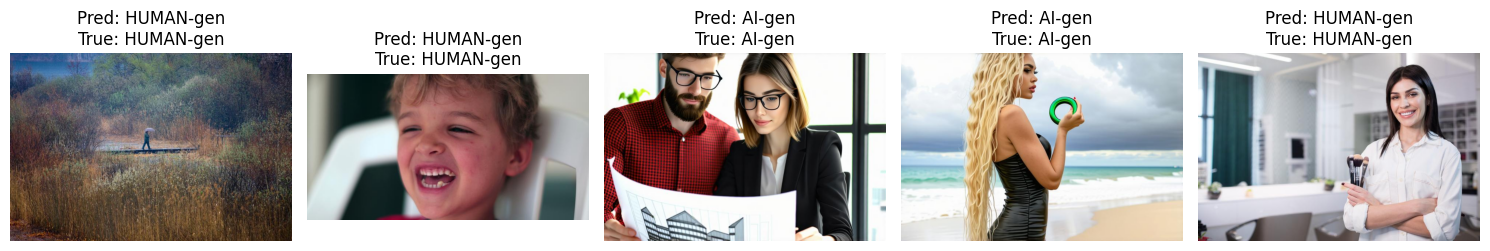

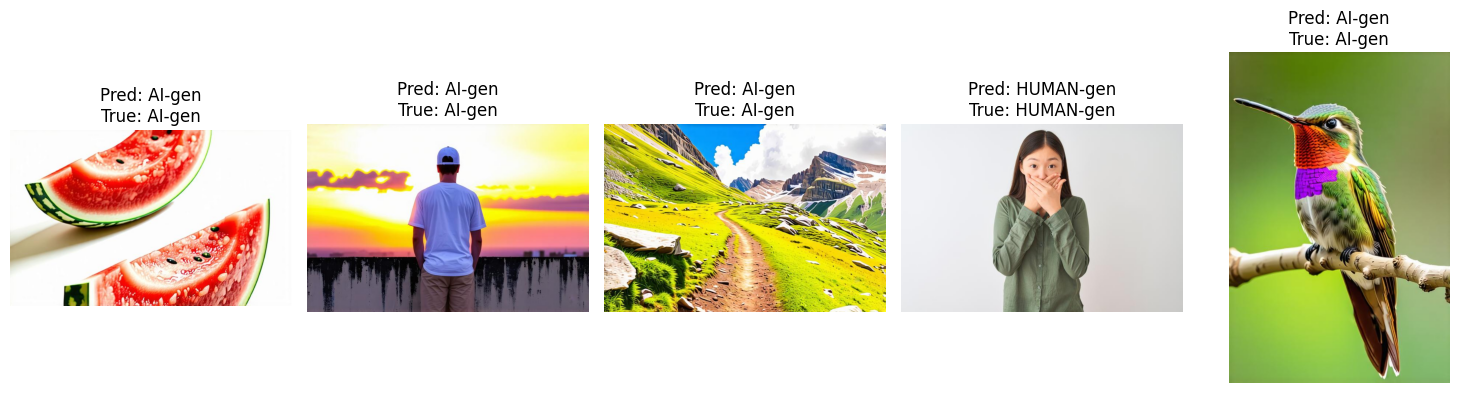

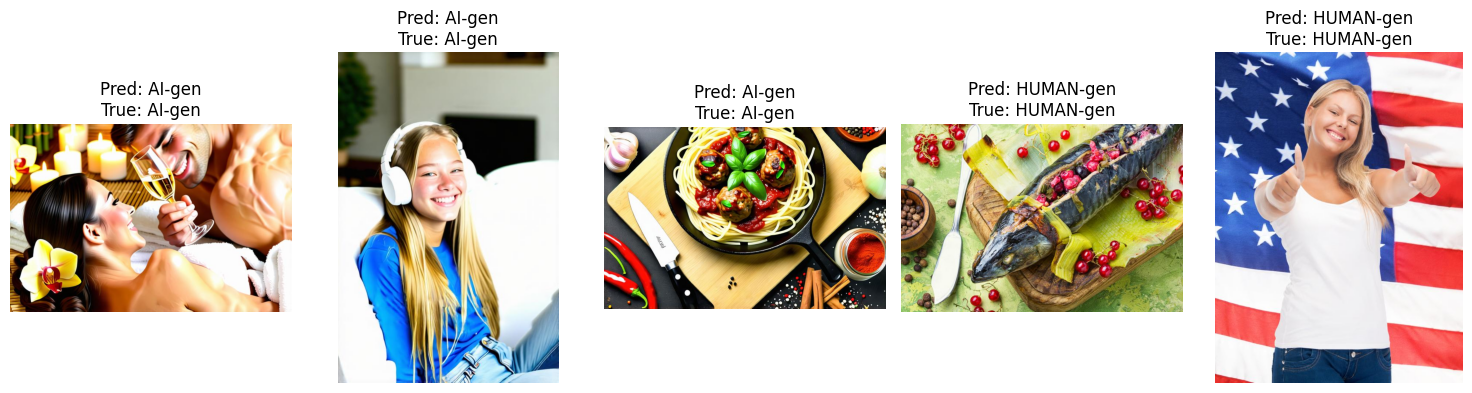

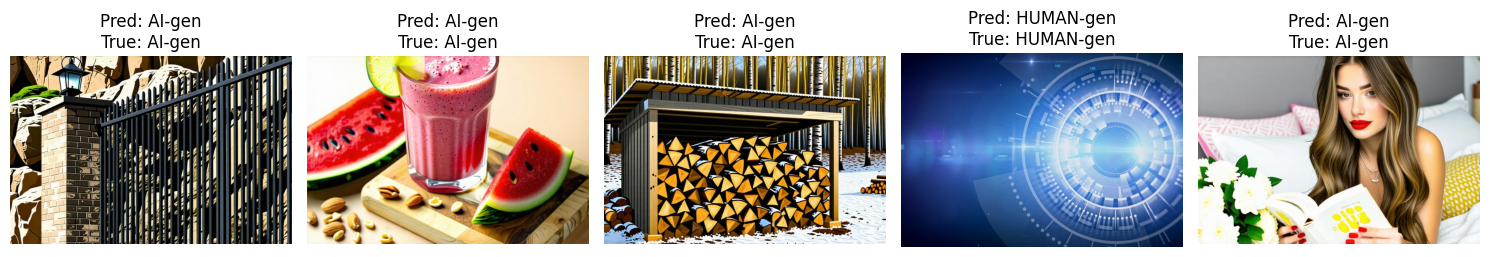

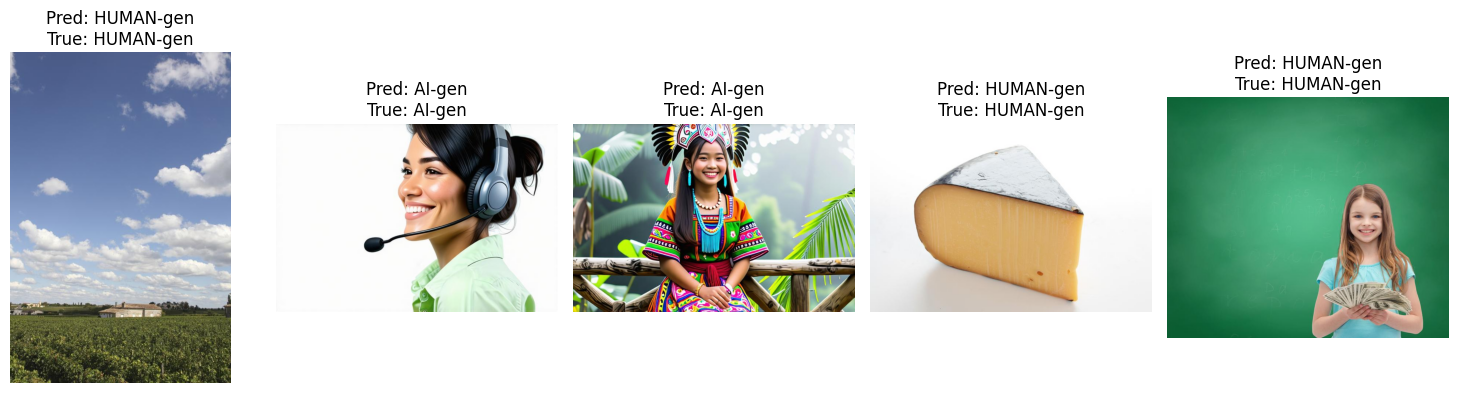

In [14]:
n_show = 40   # total images to display
per_row = 5   # images per figure

sample_df = val_data.dataset.df.sample(n_show).reset_index(drop=True)

for start in range(0, n_show, per_row):
    end = min(start + per_row, n_show)
    fig, axes = plt.subplots(1, end - start, figsize=(15, 4))
    if (end - start) == 1:
        axes = [axes]  # make iterable if only one image

    for i, ax in enumerate(axes, start=start):
        row = sample_df.iloc[i]
        img = Image.open(dataset_folder + row['filename']).convert("RGB")
        input_tensor = test_tfms(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, 1).item()

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Pred: {label_dict[pred]}\nTrue: {label_dict[row['label']]}")

    plt.tight_layout()
    plt.show()
